siddhi subhedar 1262240621 human recognition with neural networks

1.   List item
2.   List item



In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'human-activity-recognition-with-smartphones:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F226%2F793070%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241010%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241010T091155Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D708ce7bf7fc21446b9002ac8131855d32b5ab3e1ee8ab3896474619d7908974a501f13965b43c3c45d141f5a0b26f1e8f0304331a59477c95e62cc49fed923b303bc67ec50b2fa1a3528a3aff4a9d4d0d54a002e1e35117eb824dc9992b6defa509451d6ea0601b488e87da44f4173b8f3df682c283a45fd9353f8081708e854c9512be5fa2416c4721951d940786a873f3d4fae6b83ebf0b708a0c650a4d13096caaf357b648a6e6cef6f1848daef949f7d9db5f489763cb2ae18209928f3d58b70396d345271138633e46de565e26de780004cd3ff18c19e74902af942227483efc585e8a10c6863d6dadc5d6f253a9eae0b07030fcb832dacd67299ac2946'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')



[==================================================] 25693584 bytes downloaded
Downloaded and uncompressed: human-activity-recognition-with-smartphones
Data source import complete.


In [10]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os
import warnings
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
warnings.filterwarnings('ignore')

<ipython-input-11-4887cd019224>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [12]:
train_data = pd.read_csv('../input/human-activity-recognition-with-smartphones/train.csv')
test_data = pd.read_csv('../input/human-activity-recognition-with-smartphones/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)


In [13]:
pd.set_option("display.max_columns", None)


In [14]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [16]:
train_data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [15]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [17]:
train_data['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

<Axes: xlabel='Activity'>

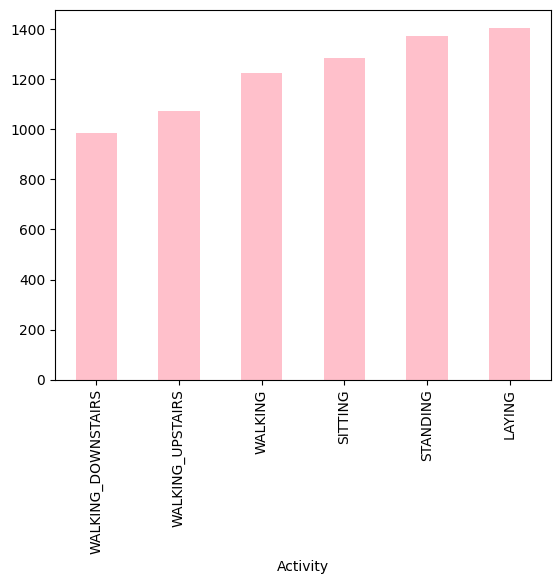

In [18]:
train_data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')


In [19]:
x_train, y_train = train_data.iloc[:, :-2], train_data.iloc[:, -1:]
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_train.shape, y_train.shape

((7352, 561), (7352, 1))

In [20]:
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_test.shape, y_test.shape

((2947, 561), (2947, 1))

In [21]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


In [22]:
x_test.shape, y_test.shape, x_train.shape, y_train.shape

((2947, 561), (2947,), (7352, 561), (7352,))

In [23]:
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_test = scaling_data.transform(x_test)


In [24]:
model = Sequential()
model.add(Dense(units=64,kernel_initializer='normal',activation='sigmoid',input_dim=x_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=6,kernel_initializer='normal',activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size = 64, epochs= 10,validation_data = (x_test,y_test))

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3682 - loss: 1.5103 - val_accuracy: 0.7017 - val_loss: 1.0381
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6909 - loss: 0.9651 - val_accuracy: 0.7177 - val_loss: 0.7638
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7937 - loss: 0.6849 - val_accuracy: 0.8677 - val_loss: 0.5498
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8499 - loss: 0.5153 - val_accuracy: 0.8432 - val_loss: 0.4446
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8783 - loss: 0.4071 - val_accuracy: 0.9141 - val_loss: 0.3523
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8916 - loss: 0.3353 - val_accuracy: 0.9050 - val_loss: 0.3053
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9124 - loss: 0.2863 - val_accuracy: 0.9063 - val_loss: 0.2724
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9140 - loss: 0.2551 - val_accuracy: 0.

In [25]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 25)):
        model.add(layers.Dense(units = hp.Int('units' + str(i), min_value=32, max_value=512, step=32),
                               kernel_initializer= hp.Choice('initializer', ['uniform', 'normal']),
                               activation= hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])))
    model.add(layers.Dense(6, kernel_initializer= hp.Choice('initializer', ['uniform', 'normal']), activation='softmax'))
    model.add(
            Dropout(0.2))
    model.compile(
        optimizer = 'adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials= 5,
    executions_per_trial=3,
    directory='project', project_name = 'Human_activity_recognition')

tuner.search_space_summary()


Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 25, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
initializer (Choice)
{'default': 'uniform', 'conditions': [], 'values': ['uniform', 'normal'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [27]:
tuner.search(x_train, y_train,
             epochs= 10,
             validation_data=(x_test, y_test))


Trial 5 Complete [00h 04m 19s]
val_accuracy: 0.18221920728683472

Best val_accuracy So Far: 0.9321343898773193
Total elapsed time: 00h 10m 51s


In [28]:
tuner.results_summary()


Results summary
Results in project/Human_activity_recognition
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_layers: 5
units0: 320
initializer: normal
activation: relu
units1: 448
units2: 224
units3: 32
units4: 352
units5: 320
units6: 288
units7: 416
units8: 256
units9: 416
units10: 64
units11: 128
units12: 320
units13: 512
units14: 224
units15: 160
units16: 128
units17: 96
Score: 0.9321343898773193

Trial 1 summary
Hyperparameters:
num_layers: 4
units0: 192
initializer: normal
activation: tanh
units1: 192
units2: 416
units3: 64
units4: 384
units5: 96
units6: 32
units7: 32
units8: 352
units9: 128
units10: 320
units11: 384
units12: 416
units13: 384
units14: 256
units15: 192
units16: 384
units17: 160
Score: 0.9256871342658997

Trial 3 summary
Hyperparameters:
num_layers: 6
units0: 64
initializer: uniform
activation: relu
units1: 352
units2: 256
units3: 448
units4: 416
units5: 256
units6: 128
units7: 320
units8: 160
units9: 384

In [29]:
model=tuner.get_best_models(num_models=1)[0]
history = model.fit(x_train,y_train, epochs=51, validation_data=(x_test,y_test))



Epoch 1/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7730 - loss: 0.7891 - val_accuracy: 0.8887 - val_loss: 1.4905
Epoch 2/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7752 - loss: 0.7926 - val_accuracy: 0.9206 - val_loss: 1.0792
Epoch 3/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7708 - loss: 0.7689 - val_accuracy: 0.8086 - val_loss: 2.5598
Epoch 4/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7683 - loss: 0.9953 - val_accuracy: 0.9406 - val_loss: 0.5687
Epoch 5/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7771 - loss: 0.8626 - val_accuracy: 0.9243 - val_loss: 0.9679
Epoch 6/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7768 - loss: 0.7799 - val_accuracy: 0.9352 - val_loss: 0.9228
Epoch 7/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7777 - loss: 0.7246 - val_accuracy: 0.9379 - val_loss: 0.6901
Epoch 8/51
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7713 - loss: 0.7500 - val_accuracy:

In [30]:
model.summary()
import tensorflow as tf

from tensorflow import keras

Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fitt = model.fit(x_train,y_train, epochs=200, validation_data=(x_test,y_test), callbacks=Callback)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 320)                 │         179,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 448)                 │         143,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 224)                 │         100,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 352)                 │          11,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           2,118 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,335,476 (5.09 MB)

 Trainable params: 445,158 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 890,318 (3.40 MB)

Epoch 1/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8265 - loss: 0.5919 - val_accuracy: 0.9457 - val_loss: 1.8260
Epoch 2/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8147 - loss: 0.7921 - val_accuracy: 0.9410 - val_loss: 1.9855
Epoch 3/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7851 - loss: 1.2391 - val_accuracy: 0.9376 - val_loss: 2.1975
Epoch 4/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8163 - loss: 0.7021 - val_accuracy: 0.9213 - val_loss: 2.1518


[0.8302502632141113, 0.8031827807426453, 0.8018226623535156, 0.8195049166679382]
4


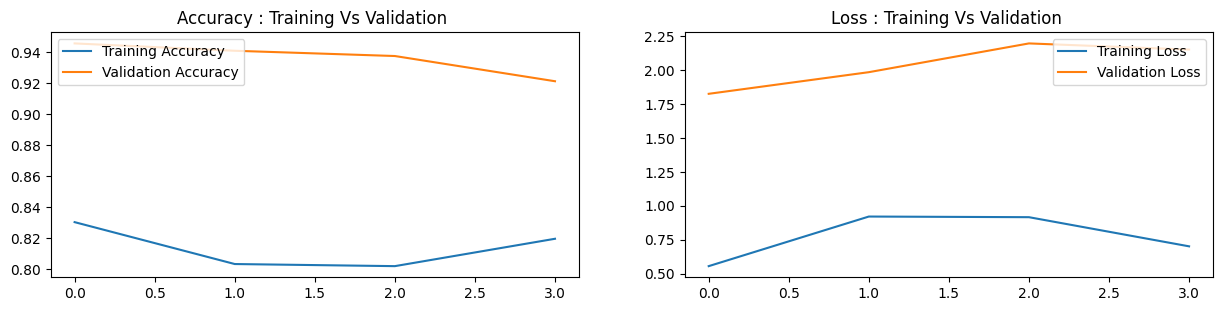

In [36]:
accuracy = mo_fitt.history['accuracy']
loss = mo_fitt.history['loss']
validation_loss = mo_fitt.history['val_loss']
validation_accuracy = mo_fitt.history['val_accuracy']

print(accuracy)
print(len(accuracy))
plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(4), accuracy, label='Training Accuracy')
plt.plot(range(4), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(4), loss, label='Training Loss')
plt.plot(range(4), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

## Conclusion :

> After hypertuning the model, it is found out that 4 layers should be there.
> Final accuracy achieved is 0.9518.

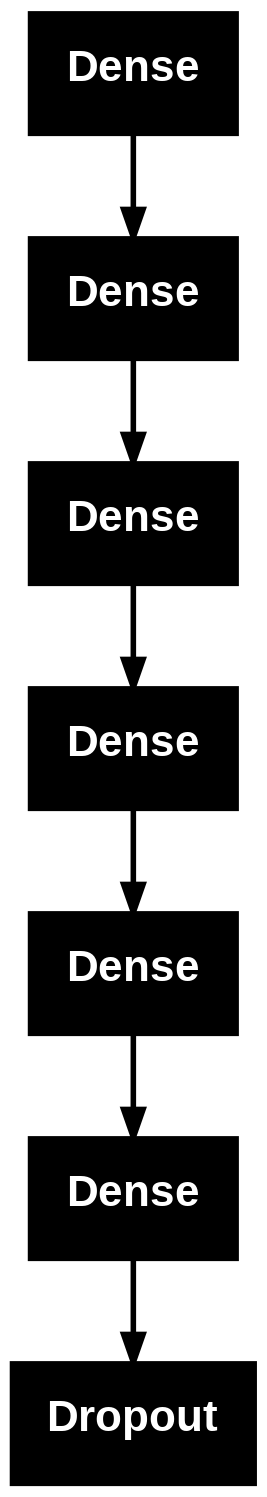

In [39]:
from tensorflow.keras.utils import plot_model

plot_model(model)